# Grand-canonical project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time, os

In [2]:
seed = 1
rng = np.random.default_rng(seed)

In [3]:
from joblib import Parallel, delayed

In [108]:
os.mkdir('Result')

FileExistsError: [Errno 17] File exists: 'Result'

In [4]:
from basic_functions import proposal, proposal_exclud_vol, energy_fun, run_Metropolis, compute_Sk

## Toy model: ideal gas
an ideal gas on a 1d lattice with PBCs (purely entropic system, without excluded-volume interactions)

In [3]:
n_sites = 1500  # n. of lattice sites
n_particles = 1400  # total n. of particles

In [4]:
sites = np.arange(n_sites)  # lattice sites

x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)  # initial configuration

- proposal move: for each particle, generate a random number $r$ uniformly distributed in (0, 1); if $r < val1$ move to the left, if $r > val2$ to the right

In [5]:
def proposal(x0, n_sites, val1=0.3, val2=0.7):

    moves = np.random.uniform(size=len(x0))

    # x1 = []
    # 
    # for i, x in enumerate(x0):
    #     if moves[0] < val1:
    #         x1[i] = x - 1
    #     elif moves[0] > val2:
    #         x1[i] = x + 1
    
    x1 = x0
    x1[moves < val1] -= 1
    x1[moves > val2] += 1

    x1 = np.mod(x1, n_sites)  # periodic boundary conditions

    return x1

- generate a trajectory

In [6]:
traj_length = 10000

In [7]:
traj = []
traj.append(x0)

for i in range(traj_length):
    x_new = +proposal(traj[-1], n_sites)
    # print(x_new)
    
    traj.append(x_new)

traj = np.array(traj)

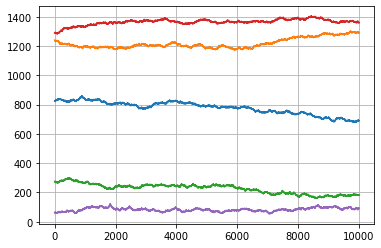

In [8]:
for i in range(5):
    # plt.plot(traj[:, i] - traj[0, i], '-')
    plt.plot(traj[:, i], '-')
    plt.grid()

### static structure factor

Now, compute the static structure factor as a function of k

In [10]:
k, Sk, Sk_list = compute_Sk(n_sites, n_particles, traj)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


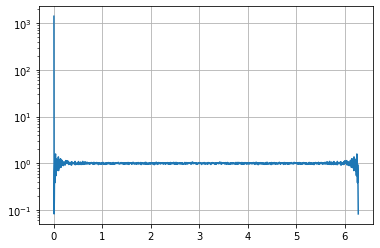

In [15]:
plt.plot(k, Sk, '-')
# plt.xscale('log')
plt.yscale('log')
plt.grid()

so:
- $S(0)=S(2\pi)=N$ total n. of particles;
- there is an intermediate regime in which $S(k)\simeq 1$, which means the particles are completely uncorrelated;
- the function

\begin{equation}
S(\vec k) = \frac{1}{N}\langle |\tilde\rho(\vec k, t)|^2\rangle_T = 
\frac{1}{N}\frac{1}{T} \sum_{t=1}^T \Big|\sum_{i=1}^N e^{i\vec k \cdot \vec r_i(t)}\Big|^2
\end{equation}

is continuous $\forall N, T$ $\forall k$, also in the limit $k\rightarrow 0$ (see in the plot fluctuations that increase in the low $\vec k$ limit), but in the thermodynamic limit $N\rightarrow\infty$ it is $S(k)=1$ $\forall k$ (infinite particles uncorrelated with each other), so discontinuity $\lim_{\vec k\rightarrow 0}S(\vec k)=1\neq S(0)=N$ 

- subsample to see statistic fluctuations

In [16]:
Sk_trial = []

for i in range(5):
    Sk_trial.append(np.mean(Sk_list[i:][::5], axis=0))

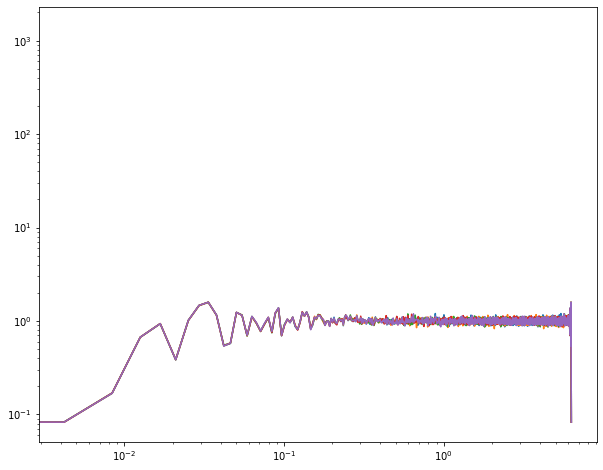

In [19]:
plt.figure(figsize=(10 , 8))

for i in range(len(Sk_trial)):
    plt.plot(k, Sk_trial[i], '-')

plt.xscale('log')
plt.yscale('log')

Conclusion:

- an ideal gas has $S(k)=1$ constant: the molecular positions are completely uncorrelated, so also $S_0=\lim_{k\rightarrow0}S(k)=1$; it follows

\begin{equation}
\frac{\partial\mu}{\partial c}\Big|_T = \frac{k_B T}{c S_0} = \frac{k_B T}{c};
\end{equation}

- in Nicola's framework, we estimate the partition function at different $n$: for an ideal gas, it is $\Omega(k) = V^k (\sqrt{2mk_B T})^{dk}$ where $d$ is the dimensionality of the space in which each particle can move and $V$ the corresponding volume; the kinetic part is depends only on the temperature, while the entropic part $V^k$ corresponds to $N_{sites}^k$ in our lattice model, which is the n. of ways $k$ particles can occupy $N_{sites}$ with repetitions. Then, we use it to get the chemical potential $\mu$ which matches the required $\langle N \rangle_\mu$. It follows

\begin{equation}
\frac{\partial\mu}{\partial \langle k\rangle}\Big|_T = \frac{k_B T}{\sigma_k^2}.
\end{equation}

- so, identification $n=\sigma_k^2$: average n. of particles equal to the variance, indeed the grand-canonical distribution for an ideal gas (independent particles) is a Poisson distribution:

\begin{equation}
Z_{GC} = \sum_{n=0}^{\infty} \frac{1}{n!} N_s^n e^{\beta\mu n}
\end{equation}

as expected, with $\langle n \rangle = \sigma_n^2 = N_s e^{\beta\mu}$.

## Toy model: excluded-volume interactions

for example, excluded-volume interaction, and/or an energy value (penalty/gain) for close particles

- the Metropolis algorithm defined below requires the proposal move to be symmetric

- include the excluded-volume interactions already in the proposal move (exclude them from the configuration space); in this case, take the energy function as constant

### run Metropolis and get a trajectory

In [5]:
n_sites = 10
n_particles = 5

sites = np.arange(n_sites)

In [6]:
x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)

In [7]:
x0

array([3, 0, 6, 8, 2])

In [8]:
proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, 5/(2*n_particles), 1)}  # n_sites, 0.3, 0.7)}

In [9]:
proposal_full['fun'](x0, *proposal_full['args'])

array([86, 42, 27, 82, 25])

In [23]:
times = {}

for n_particles in range(1, n_sites, 20):

    print(n_particles)
    
    t = time.time()
    
    x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)
    proposal_full['fun'](x0, *proposal_full['args'])

    dt = time.time() - t
    print(dt)

    times[n_particles] = dt

1
0.0005512237548828125
21
0.0007386207580566406
41
0.00033164024353027344
61
0.00037932395935058594
81
0.0003516674041748047
101
0.0006465911865234375
121
0.006207466125488281
141
0.0013620853424072266
161
0.0012390613555908203
181
0.00077056884765625
201
0.001233816146850586
221
0.0008444786071777344
241
0.0008897781372070312
261
0.0010988712310791016
281
0.001556396484375
301
0.0007750988006591797
321
0.0008482933044433594
341
0.0013365745544433594
361
0.0010030269622802734
381
0.0006394386291503906
401
0.0011892318725585938
421
0.0006246566772460938
441
0.0013129711151123047
461
0.004550457000732422
481
0.005121469497680664
501
0.0028128623962402344
521
0.011996984481811523
541
0.0019428730010986328
561
0.0043621063232421875
581
0.0015571117401123047
601
0.0035886764526367188
621
0.0015490055084228516
641
0.0010824203491210938
661
0.017313003540039062
681
0.004129648208618164
701
0.008174657821655273
721
0.020411252975463867
741
0.020022153854370117
761
0.07586789131164551
781
0.00

clearly, it strongly depends on how many particles do move!

In [14]:
ene0 = +5
ene1 = -1

energy_function_full = {'fun': LJlike_energy, 'args': (ene0, ene1, n_sites)}

In [24]:
energy_function_full = {'fun': lambda x : 0, 'args': ()}

In [78]:
traj, ene, av_alpha = run_Metropolis(x0, proposal_full, energy_function_full, n_steps=1000)


x0:  [647 748 812 377 439 477 803 128 835 301 587 446 814 261 299  82 763 486
 193 683 247 719 777 723  85 670 534 788 982  93 442 392 813 333  64 871
 154 431 361 997 232 423 965 672 739 811 520 491 853 420 952 217 557 887
 924 220 384 347 216 254 181 729 568 858  96 677 867 971 659 367 995 689
 288  89  54 583 468 472 705 134 969 648 298 711 315 435 208 772 865 357
 656 244   6 411 602 706 414 228 352 575 898 722 839 894 188 159 496  45
 823 327 455 931 685 119 773 146 372 911 325 775 781 482 766 837 594  28
 626 749 868 478 864  11 337 951 565 796 380 354 184 768 386 212 291 978
 152 339 960 183 821 312 841 394  79 342 562   9 381  69 996 946  16  32
 250 528 264 229 165 750 514  50  23 356 653 632 564 133  53 242 731 990
 479  29 954 621 450 438  36  67  77 907 999 474 599 875  19 136 243 206
 168 494 561  30 998 405  15 745 393 316  94 148   0 688 740 207 902 543
 738 579 427 161 869 389 644 662 942 747 174 470 363 654 929 286 451 350
 385 919 131 221 615 304 586 505 657  92 751 1

In [79]:
print(traj)

[[647 748 812 ... 346 504 142]
 [647 748 812 ... 346 504 142]
 [647 748 812 ... 346 504 142]
 ...
 [647 748 812 ... 346 504 142]
 [647 748 812 ... 346 504 142]
 [647 748 812 ... 346 504 142]]


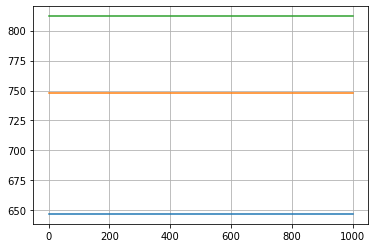

In [80]:
for i in range(3):
    plt.plot(traj[:, i], '-')

plt.grid()
# plt.xlim((60,80))

### analyse the trajectory

In [151]:
ene

array([-1, -2, -2, ..., -1, -1, -1])

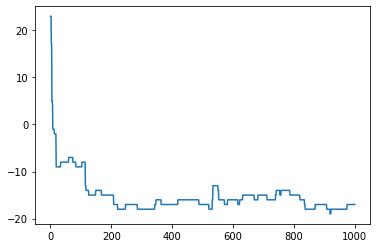

In [250]:
plt.plot(ene, '-')

In [137]:
hists = []
avs_dist = []

for i in range(traj.shape[0]):
    dist = compute_NN_distances(traj[i, :])

    av_dist = np.mean(dist)

    hist = np.histogram(dist, sites)[0]
    # better: add a further site to make the histogram
    # np.histogram([0, 1, 2, 3, 4], np.arange(6))

    avs_dist.append(av_dist)
    hists.append(hist)

hists = np.array(hists)

In [125]:
t = 50

traj[t, :]

array([ 2,  5, 17,  1, 11])

In [240]:
np.sort(traj[t, :])

array([ 1,  4,  4,  4, 10, 12, 16, 22, 36, 45, 46, 47, 53, 53, 60, 62, 62,
       63, 64, 67, 71, 76, 77, 80, 86, 87, 89, 90, 94, 95])

In [239]:
compute_NN_distances(traj[t, :])

array([ 3,  0,  0,  6,  2,  4,  6, 14,  9,  1,  1,  6,  0,  7,  2,  0,  1,
        1,  3,  4,  5,  1,  3,  6,  1,  2,  1,  4,  1])

In [237]:
t = 4
print(ene[4])

hists[t, 0]*5 + hists[t, 1]*(-1)

3


1

In [235]:
energy_function_full['fun'](traj[t, :], *energy_function_full['args'])

12

In [221]:
compute_energy(traj[t, :])#, ene0=10, ene1=-1)

13

In [236]:
energy_function_full

{'fun': <function __main__.compute_energy(xs, ene0=2, ene1=1, n_sites=100)>,
 'args': (5, -1, 100)}

In [222]:
energy_function_full['fun'](traj[t, :], *energy_function_full['args'])

11

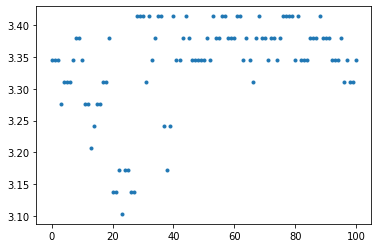

In [30]:
plt.plot(avs_dist, '.')

In [146]:
hists.shape

(101, 99)

In [147]:
traj[-1, :]

array([ 67,  32,  91,  11,  96,  59,  77,  73,  71,  45,  40,  22,   2,
        36,  88,  99,  93,  13, 101,  89,  75,  85,  80,  37,  89,  57,
        68,  34,  31,  34])

In [166]:
ene[1]

33

In [167]:
t = 1
hists[t, 0]*10 + hists[t, 1]*(-1)

54

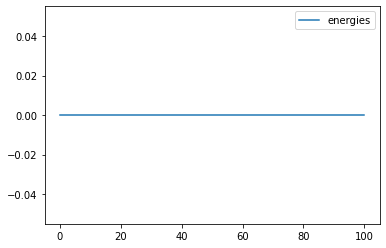

In [31]:
# plt.plot(hists[:, 0])
plt.plot(ene, label='energies')
# plt.plot(hists[:, 0]*10 + hists[:, 1]*(-1), label='my energies')
plt.legend()

In [110]:
ene

array([ 6,  6,  6,  6,  6,  6,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  9,  9, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1])

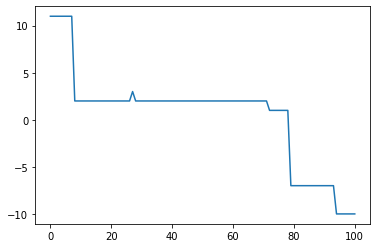

In [73]:
plt.plot(ene, '-')

In [63]:
x0

array([ 333, 1045,  612, ...,  757,  594,   17])

In [59]:
traj

array([[421, 516, 292, ..., 826, 464, 885],
       [421, 515, 292, ..., 825, 465, 885],
       [420, 514, 292, ..., 826, 465, 886],
       ...,
       [407, 528, 312, ..., 856, 516,   1],
       [408, 527, 313, ..., 856, 517,   0],
       [408, 527, 312, ..., 857, 518, 999]])

In [62]:
traj[0, :]

array([ 333, 1045,  612, ...,  757,  594,   17])

In [129]:
traj[0, :]

array([14, 15, 14, 11,  6])

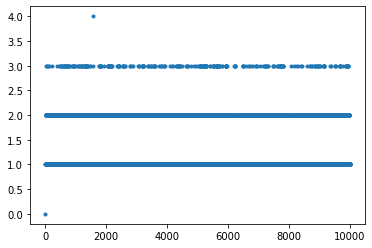

In [128]:
my_vec = [np.min(compute_NN_distances(traj[i, :], n_sites)) for i in range(traj.shape[0])]

plt.plot(my_vec, '.')

In [51]:
xs = x0

In [52]:
sorted_xs = np.sort(xs)
vec = np.ediff1d(sorted_xs)

if n_sites is not None:
    vec = np.append(vec, sorted_xs[0] + n_sites - sorted_xs[-1])

vec

array([1, 1, 1, ..., 1, 1, 2])

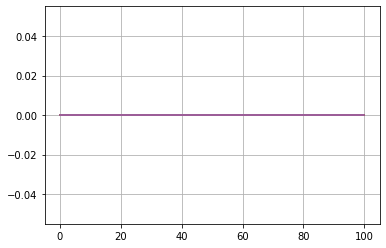

In [263]:
for i in range(5):  # np.shape(traj)[1]):
    plt.plot(traj[:, i] - traj[0, i], '-')
    # plt.plot(traj[:, i], '-')
    plt.grid()

### compute static structure factor

In [14]:
k, Sk, Sk_list = compute_Sk(n_sites, traj)

0
100
200


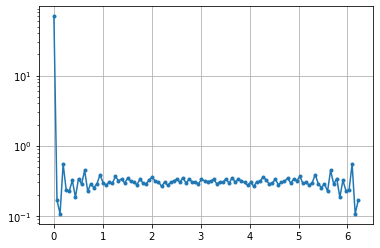

In [15]:
plt.plot(k, Sk, '.-')
plt.yscale('log')
plt.grid()

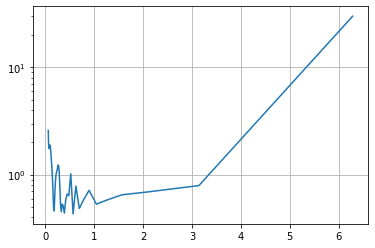

In [238]:
plt.plot(k, Sk, '-')
plt.yscale('log')
plt.grid()

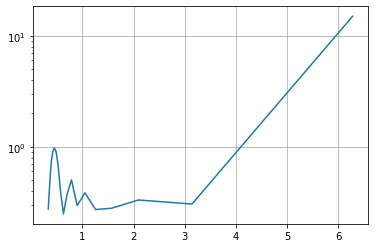

In [180]:
plt.plot(k, Sk, '-')
plt.yscale('log')
plt.grid()

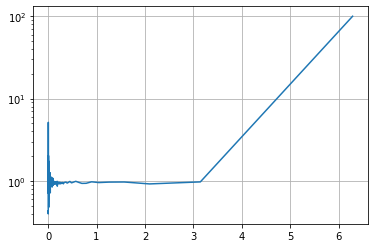

In [92]:
plt.plot(k, Sk, '-')
plt.yscale('log')
plt.grid()

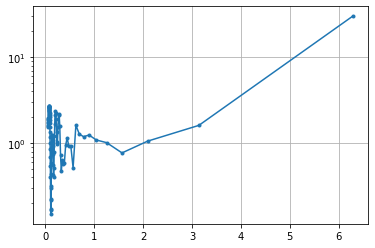

In [39]:
plt.plot(k, Sk, '.-')
plt.yscale('log')
plt.grid()

### repeat for different concentrations
namely, n. of particles

In [5]:
n_sites = 10
delta = 2
n_steps = 2

sites = np.arange(n_sites)

list_n_particles = np.arange(delta, n_sites, delta)

In [6]:
print(list_n_particles)

n_particles = list_n_particles[0]

[2 4 6 8]


In [7]:
proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, 0.2)}  # delta/(n_particles + 1))}  # n_sites, 0.3, 0.7)}

energy_function_full = {'fun': lambda x : 0, 'args': ()}

In [12]:
Sk_n = []

for n_particles in list_n_particles:

    print('n. of particles: ', n_particles)

    x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)
    
    proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, delta/(2*n_particles))}  # n_sites, 0.3, 0.7)}

    traj, ene, av_alpha = run_Metropolis(x0, n_steps=n_steps, proposal=proposal_full, energy_function=energy_function_full)
    
    k, Sk, Sk_list = compute_Sk(n_sites, n_particles, traj)
    # k, Sk = compute_Sk_faster(n_sites, n_particles, traj)

    Sk_n.append(Sk)

n. of particles:  2
x0:  [9 4]


AssertionError: error: val must be < 0.5

compute_Sk_faster and parallelize it!

In [17]:
def run_and_compute_Sk(n_particles, sites, n_steps):

    print('n. particles: ', n_particles)
    
    x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)
    
    traj, ene, av_alpha = run_Metropolis(x0, n_steps=n_steps, proposal=proposal_full, energy_function=energy_function_full)
    
    k, Sk, Sk_list = compute_Sk(n_sites, n_particles, traj)

    return Sk

In [22]:
run_and_compute_Sk(delta, sites, 1000)

n. particles:  2
x0:  [8 2]
computing Sk...
done


array([2.        , 0.19098301, 1.30901699, 1.30901699, 0.19098301,
       2.        , 0.19098301, 1.30901699, 1.30901699, 0.19098301])

In [9]:
output = Parallel(n_jobs=3)(delayed(run_and_compute_Sk)(n, sites, 1000) for n in list_n_particles)


KeyboardInterrupt: 

In [15]:
output

[array([2.00000000e+00, 1.80901699e+00, 1.30901699e+00, 6.90983006e-01,
        1.90983006e-01, 7.49879891e-33, 1.90983006e-01, 6.90983006e-01,
        1.30901699e+00, 1.80901699e+00]),
 array([4.00000000e+00, 3.45491503e-01, 5.95491503e-01, 9.04508497e-01,
        1.15450850e+00, 1.49975978e-32, 1.15450850e+00, 9.04508497e-01,
        5.95491503e-01, 3.45491503e-01]),
 array([6.        , 0.436339  , 0.39699434, 0.063661  , 0.76967233,
        0.66666667, 0.76967233, 0.063661  , 0.39699434, 0.436339  ]),
 array([8.        , 0.32725425, 0.04774575, 0.04774575, 0.32725425,
        0.5       , 0.32725425, 0.04774575, 0.04774575, 0.32725425])]

In [18]:
path_list = os.listdir('Results')

path_list

['Result_2024_11_05_18_00_38_926075',
 'Result_2024_11_05_18_05_40_797637',
 'Result_2024_11_05_18_05_40_797771',
 'Result_2024_11_06_09_42_25_251235']

In [24]:
Sk = {}

for i_choice in range(len(path_list)):

    Sk[i_choice] = {}

    path = 'Results/' + path_list[i_choice] + '/'

    file_list = [s for s in os.listdir('Results/' + path_list[i_choice]) if s[:2] == 'Sk']

    for s in file_list:
        i = int(s[3:][:-4])
        Sk[i_choice][i] = np.load(path + s)

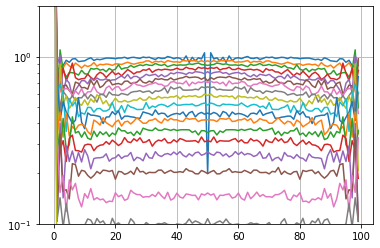

In [27]:
for i in sorted(Sk[2].keys()):
    plt.plot(Sk[2][i], '-', label=i)
    # plt.plot(Sk1[i], '-', label=i)

plt.grid()
# plt.legend(bbox_to_anchor=(1.1, 1.1))

plt.ylim([0.1, 2])
plt.yscale('log')

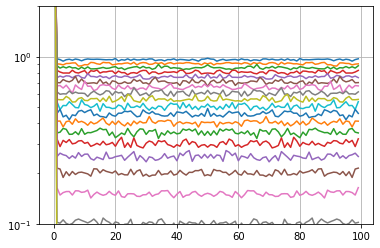

In [28]:
for i in sorted(Sk[3].keys()):
    plt.plot(Sk[3][i], '-', label=i)

plt.grid()
# plt.legend(bbox_to_anchor=(1.1, 1.1))

plt.ylim([0.1, 2])
plt.yscale('log')

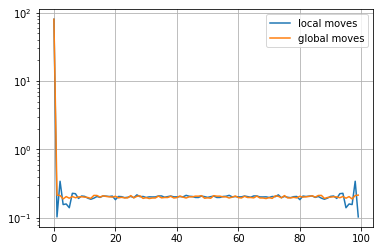

In [36]:
plt.plot(Sk[2][80], '-', label='local moves')
plt.plot(Sk[3][80], '-', label='global moves')

plt.yscale('log')
plt.legend()
plt.grid()

In [29]:
n_sites = 100

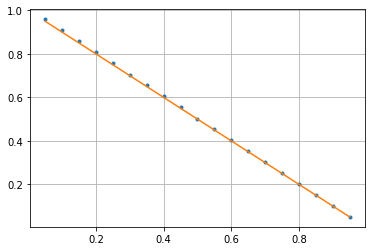

In [30]:
c = np.array(sorted(Sk[3].keys()))/n_sites
av_values = [np.mean(Sk[3][i][10:50]) for i in sorted(Sk[3].keys())]

plt.plot(c, av_values, '.')
plt.plot(c, 1 - c, '-')
plt.grid()

In [374]:
values = range(1, n_sites, 20)

values

range(1, 100, 20)

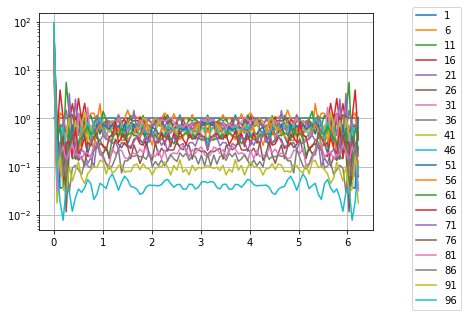

In [23]:
stride = 1

for i, s in enumerate(Sk_n[::stride]):
    plt.plot(k, s, '-', markersize=3, label=values[::stride][i])

plt.yscale('log')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.grid()

# plt.xlim([2, 3])
# plt.ylim([2e-2, 2])

- $S_0 < 1$, so the chemical potential increases with the concentration faster than in the ideal gas, due to interactions

- moreover, increasing the concentration $S_0$ decreases, so the chemical potential increases faster and faster with the concentration; remember that the chemical potential tells how much the energy increases when adding one/some particles to the system; at a certain point, due to hard-sphere interactions, you cannot add particles anymore, namely, the energy would become infinite, so the chemical potential diverges

$\frac{\partial \mu}{\partial c} \Big|_{T,V} = \frac{k_B T}{c}\frac{1}{S_0}$

- in this case, we get the Fermi-Dirac statistics with

\begin{equation}
\langle n \rangle(\mu) = N_s \frac{1}{1+e^{-\beta\mu}}
\end{equation}

so by computing the derivative, then, if the fluctuation-compressibility relation holds, it is

\begin{equation}
S_0 = \frac{1}{e^{\beta\mu} + 1} = 1 - c
\end{equation}

where $c=\langle n\rangle/N_s$ is the concentration of particles.

#### match required $\langle N\rangle$

### compare with analytical calculations
compare this plot of $S(k)$ given by trajectories with analytical calculations both of $\sigma^2_N/\langle N\rangle$ over the GC ensemble and $1/N \langle |\rho(\vec q)|^2 \rangle$ averaged over the canonical ensemble 

In [9]:
from scipy.special import comb # number of combinations
from scipy.special import binom # the same as comb but maybe faster

# https://stackoverflow.com/questions/26560726/python-binomial-coefficient

from itertools import combinations

In [10]:
arr = [1, 2, 3, 4]
r = 2

list(combinations(arr, r))

[(1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]

In [12]:
n_sites = 20
n_particles = 10

print(comb(n_sites, n_particles))
print(binom(n_sites, n_particles))

184756.0
184756.0


In [13]:
arr = np.arange(n_sites)

configs = list(combinations(arr, n_particles))
print(len(configs))

184756


In [14]:
out = compute_Sk(n_sites, n_particles, np.array(configs))

computing Sk...
done


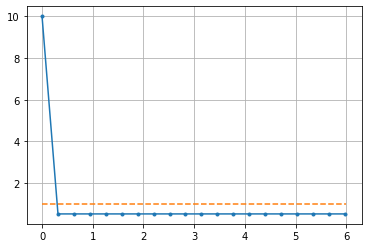

In [15]:
plt.plot(out[0], out[1], '.-')
plt.plot([0, 6], [1, 1], '--')
plt.grid()

In [16]:
Sk = {}

for n_particles in range(1, n_sites + 1):

    configs = list(combinations(arr, n_particles))
    print(n_particles, len(configs))

    out = compute_Sk(n_sites, n_particles, np.array(configs))

    Sk[n_particles] = out[1]
    

1 20
computing Sk...
done
2 190
computing Sk...
done
3 1140
computing Sk...
done
4 4845
computing Sk...
done
5 15504
computing Sk...
done
6 38760
computing Sk...
done
7 77520
computing Sk...
done
8 125970
computing Sk...
done
9 167960
computing Sk...
done
10 184756
computing Sk...
done
11 167960
computing Sk...
done
12 125970
computing Sk...
done
13 77520
computing Sk...
done
14 38760
computing Sk...
done
15 15504
computing Sk...
done
16 4845
computing Sk...
done
17 1140
computing Sk...
done
18 190
computing Sk...
done
19 20
computing Sk...
done
20 1
computing Sk...
done


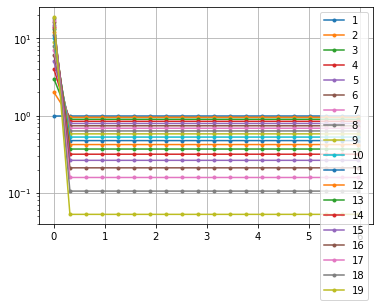

In [17]:
for n in list(Sk.keys())[:-1]:
    plt.plot(out[0], Sk[n], '.-', label=n)

plt.yscale('log')
plt.legend()
plt.grid()

if the GC ensemble can be confounded with the canonical ensemble, it is $S_0 = 1-c$ where c is the concentration of particles

In [22]:
vec1 = [Sk[n][1] for n in Sk.keys()]

In [33]:
c = np.array(list(Sk.keys()))/20  # np.arange(1, 21)/20

vec2 = 1 - c

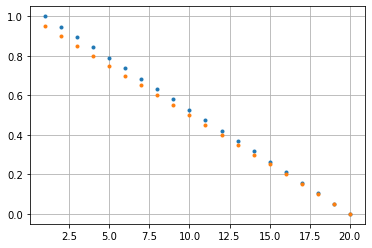

In [34]:
plt.plot(Sk.keys(), vec1, '.')
plt.plot(Sk.keys(), vec2, '.')
plt.grid()

In [136]:
n_combs = {}

for n_particles in range(1, n_sites + 1):
    n_combs[n_particles] = comb(n_sites, n_particles)

In [150]:
def compute_GC_av(betamu, partition_fs, quantities, if_normalized=True):
    
    Zgc = np.sum([np.exp(betamu*k)*partition_fs[k] for k in partition_fs.keys()])

    if isinstance(quantities, float) or isinstance(quantities, int):
        print('just the partition f. times quantities')
        out = Zgc*quantities
    
    elif isinstance(quantities, np.ndarray):
        out = np.sum([np.exp(betamu*k)*partition_fs[k]*quantities[i] for i, k in enumerate(partition_fs.keys())])

    elif isinstance(quantities, dict):
        out = np.sum([np.exp(betamu*k)*partition_fs[k]*quantities[k] for k in partition_fs.keys()])

    if if_normalized:
        out = out/Zgc

    return out

In [152]:
quantities = np.arange(1, n_sites + 1)**2

In [153]:
compute_GC_av(1, n_combs, quantities)

55.41089356254901

In [159]:
betamu = 0.85

ns = np.array(list(n_combs.keys()))  # n. of particles

av_n = compute_GC_av(betamu, n_combs, ns)
av_n2 = compute_GC_av(betamu, n_combs, ns**2)

print(av_n, av_n2)

var_n = av_n2 - av_n**2
ratio = var_n/av_n

print(var_n, ratio)

7.005712017336008 51.177456858161946
2.0974559883157866 0.29939226492974874


## Toy model: Lennard-Jones-like particles

### Ornstein-Zernike relation

In the most general case, we expect that in the long wavelength limit $\vec k \rightarrow 0$ the Ornstein-Zernike relation to hold

\begin{equation}
S(\vec k)\simeq \frac{S^0}{1+k^2\xi^2}.
\end{equation}

Notice this does not hold for hard-sphere particles, since there are not correlations on scales longer than one lattice site (namely, no interaction between particles, except for excluded-volume one).

In the case of binary mixtures, it is

\begin{equation}
S_{AB}(\vec k) \simeq \frac{S_{AB}^0}{1+k^2\xi_A \xi_B}
\end{equation}

where $\xi_A,\xi_B$ are characteristic lengths (the Debye persistence lengths), so $\xi_A,\xi_B>0$ (?).

Why, in Bingqing work **Computing chemical potentials of solutions from structure factors**, the fit in Fig. 2a is increasing with $k$, but looking at eq. 18, it should decrease since both $\xi$ are positive? Maybe they are not always positive for binary mixtures? Here, also S(k) is negative, while for single chemical species it is positive by definition...

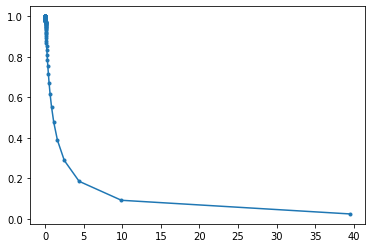

In [ ]:
plt.plot(k**2, 1/(1 + k**2), '.-')

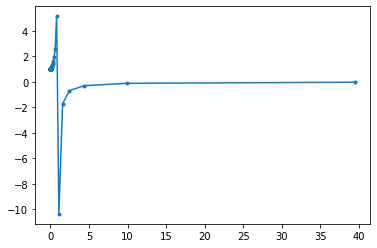

In [ ]:
plt.plot(k**2, 1/(1 - k**2), '.-')

### run Metropolis with LJ-like potential

you should be able to see a phase transition between liquid and solid behaviour (?)

In [11]:
n_sites = 100
delta = 5
n_steps = 5000

sites = np.arange(n_sites)

list_n_particles = np.arange(delta, n_sites, delta)

In [12]:
print(list_n_particles)

# n_particles = list_n_particles[0]
n_particles = 9

[ 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95]


In [13]:
proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, 0.2)}  # delta/(n_particles + 1))}  # n_sites, 0.3, 0.7)}

energies_pen = {'1': 5, '2': -7, '3': -2}
energy_function_full = {'fun': energy_fun, 'args': (energies_pen, n_sites)}

In [8]:
x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)

proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, 1/(2*n_particles), 1)}  # n_sites, 0.3, 0.7)}

traj, ene, av_alpha = run_Metropolis(x0, n_steps=n_steps, proposal=proposal_full, energy_function=energy_function_full)


x0:  [43 93 90 13  3 47 24 80 70]


In [14]:
Sk_hardsph = {}

for n_particles in list_n_particles:

    print('n. particles: ', n_particles)
    
    # proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, delta/(2*n_particles))}  # n_sites, 0.3, 0.7)}

    # energies_pen = {'1': 7}  # , '2': 5, '3': 2}
    energy_function_full = {'fun': energy_fun, 'args': (energies_pen, n_sites)}

    # energy_function_full = {'fun': lambda x : 0, 'args': ()}

    x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)

    proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, 1/(2*n_particles), 1)}  # n_sites, 0.3, 0.7)}

    traj, ene, av_alpha = run_Metropolis(x0, n_steps=n_steps, proposal=proposal_full, energy_function=None)

    out = compute_Sk(n_sites, n_particles, traj)

    Sk_hardsph[n_particles] = out[1]

x0:  [97 50 65 75 48]
computing Sk...
x0:  [78 35 70 73 53 19 18 62  6 82]
computing Sk...
x0:  [ 0 59 76 81 23 24 40 53 46 96 27 39 21 67 80]
computing Sk...
x0:  [21  2 81 84 74 62 42 46 25 80 41 65 73 39 87  6 48 57 23 75]
computing Sk...
x0:  [63 39 58 53  8  0 65 49 26 30 32 43  2 81 79 82 20 96 48 94 14 33 60 44
 34]
computing Sk...
x0:  [58 44 34 56 29 31 33 97 67 46 41 23 93 48 47 12 55 35 13 90 18 65 37  9
 30  3 26 16 92 89]
computing Sk...
x0:  [78 49 62 54  9 53 29 63 75 67 35 33 91 95 59 57  1 69 84 96 20 72  8 52
 60 90 50  6 92 93 81 66 10 22 15]
computing Sk...
x0:  [40 57 35 76  1 63 24 91 46 77 43 73 16 18 11 13 62 38 21 89  2 50 12 17
 93 34 55 69 30 20 56 28 33 52 98 27 78 29 90 39]
computing Sk...
x0:  [18 94 84 31 62 82 11 40 22 25 64  1 80 57 33 12 78  2 61 97 87 45 44 92
 30 54 34  9 53 59  3 74  8 35 14 81 29 39 76 96 56 90 66 28 46]
computing Sk...
x0:  [30 89 64 86 98 45 31  8 82  5 66 56 13 46 75 11 19 43 68 53 74  3  7 80
 29 63 72 81 85 91 57 37 42 67 26 6

KeyboardInterrupt: 

In [19]:
Sk = {}

for n_particles in list_n_particles:
    
    # proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, delta/(2*n_particles))}  # n_sites, 0.3, 0.7)}

    # energies_pen = {'1': 7}  # , '2': 5, '3': 2}
    energy_function_full = {'fun': energy_fun, 'args': (energies_pen, n_sites)}

    # energy_function_full = {'fun': lambda x : 0, 'args': ()}

    x0 = rng.choice(np.shape(sites)[0], size=n_particles, replace=False)

    proposal_full = {'fun': proposal_exclud_vol, 'args': (n_sites, 1/(2*n_particles), 1)}  # n_sites, 0.3, 0.7)}

    traj, ene, av_alpha = run_Metropolis(x0, n_steps=n_steps, proposal=proposal_full, energy_function=energy_function_full)

    out = compute_Sk(n_sites, n_particles, traj)

    Sk[n_particles] = out[1]

x0:  [27 98 42 96 15]
computing Sk...
x0:  [11 75 59 19  3 83 10 15 52  1]
computing Sk...
x0:  [11 86 77 38 23 94 50 63 82 92 21 16 58 97 34]
computing Sk...
x0:  [56 80 67  0  7 25 97 68 34 94 21 61 13 45 69 88 76 10 24 36]
computing Sk...
x0:  [58 84 93 56 80 60 82 73 25 23 15 27 30 53  7  1 50 22 29 36 86 54 20 35
 71]
computing Sk...
x0:  [20 31 54  6 30 88 15 96 94 44 52  7 75 29 73 12 24 70 21 55 76 66 93 56
 51 23 61 32 65 80]
computing Sk...
x0:  [ 3 71 73 78 77 54  1 85 24 66 99 90 21 40 81 49 47 96 27 22 69 62 75 72
 23  0 45  9 67 87 64 41 97  4 60]
computing Sk...
x0:  [72  6 92 31 98 41 67 73 18 30 62 83 46 59 65 61 34 38 36 32 87 76 50 12
 99 48 28 97 71 35 96 81  5 29 33 14 90 40 52 85]
computing Sk...
x0:  [79 83 16 32 91 84 28 38 53 73 42 49 66  4 35 51 12 29 18 88  5 34 19 20
 86 57 61 40 44  3 11 69 97  6 71  8 37 39  0 23  9 90 15 81 60]
computing Sk...
x0:  [87  1 94 47 95 63 19 64  6 75 50 70 79 98 45 60 32 59 14 62 55 34 68 26
 73 20 48  5 16 61 15 88 35 25 91 8

KeyboardInterrupt: 

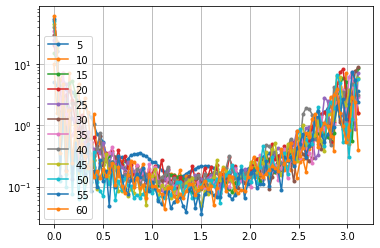

In [21]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

plt.yscale('log')
# plt.ylim([0.3, 1.1])
plt.legend()
plt.grid()

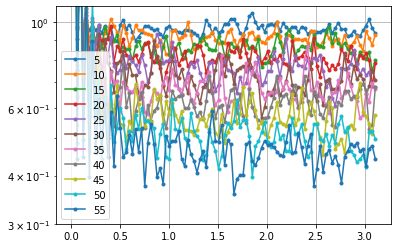

In [18]:
for i in Sk_hardsph.keys():
    plt.plot(out[0], Sk_hardsph[i], '.-', label=i)

plt.yscale('log')
plt.ylim([0.3, 1.1])
plt.legend()
plt.grid()

In [7]:
np.arange(5, 75, 5)

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70])

In [13]:
file_names = os.listdir('../Results/')

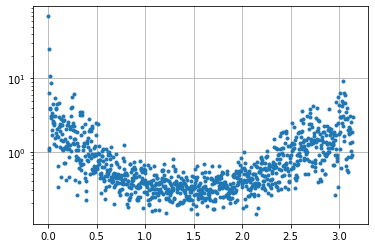

In [100]:
Sk = {}

dates = []

for i in np.arange(5, 75, 5):
    Sk[i] = np.load('../Results/' + file_names[-1] + '/Sk_%i.npy' % i)

n_sites = 1000
ks = np.pi/n_sites*np.arange(n_sites)

# for n in Sk.keys():
#     plt.plot(ks, Sk[n], '-')

plt.plot(ks, Sk[70], '.')

# plt.plot(ks, 2.2/(1 + 5.8*ks**2), '.')


plt.yscale('log')
# plt.ylim(top=2)
plt.grid()

In [77]:
from scipy import optimize

[2.71893737 7.46929249] [[0.01822814 0.10355892]
 [0.10355892 1.11060789]]


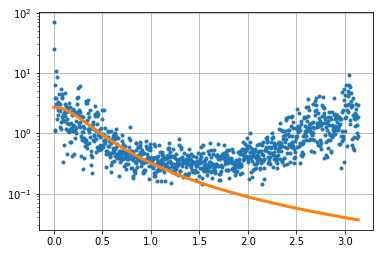

In [105]:
def func(x, S0, xi2):
    return S0/(1 + xi2*x**2)

popt, pcov = optimize.curve_fit(func, ks[5:][:400], Sk[60][5:][:400])

print(popt, pcov)

s0 = popt[0]
xi2 = popt[1]

plt.plot(ks, Sk[70], '.')
plt.plot(ks, func(ks, *popt), '-', linewidth=3)
plt.yscale('log')
plt.grid()

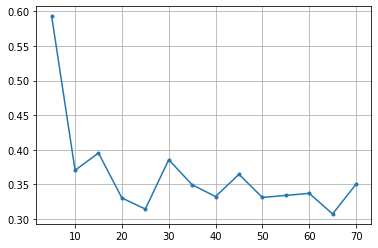

In [48]:
wh = np.argwhere([(ks > 1) & (ks < 2)])[:, 1]

mean_Sk = {}

for n in Sk.keys():
    mean_Sk[n] = np.mean(Sk[n][wh])

plt.plot(Sk.keys(), mean_Sk.values(), '.-')
plt.grid()

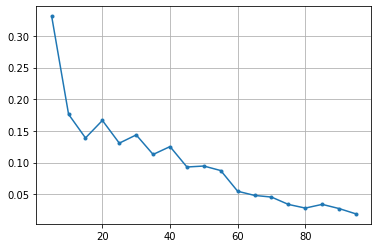

In [45]:
wh = np.argwhere([(ks > 1) & (ks < 2)])[:, 1]

mean_Sk = {}

for n in Sk.keys():
    mean_Sk[n] = np.mean(Sk[n][wh])

plt.plot(Sk.keys(), mean_Sk.values(), '.-')
plt.grid()


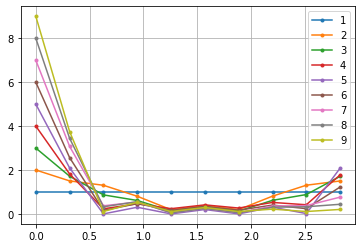

In [12]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

# plt.yscale('log')
plt.legend()
plt.grid()

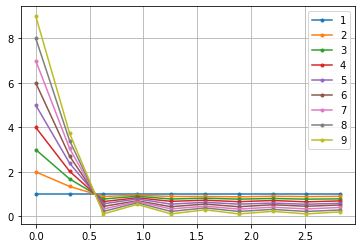

In [10]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

# plt.yscale('log')
plt.legend()
plt.grid()

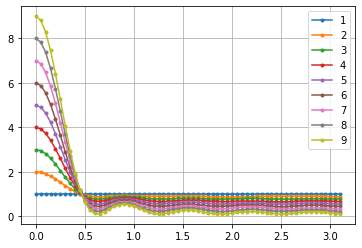

In [43]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

# plt.yscale('log')
plt.legend()
plt.grid()

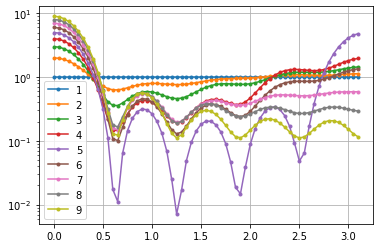

In [39]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

plt.yscale('log')
plt.legend()
plt.grid()

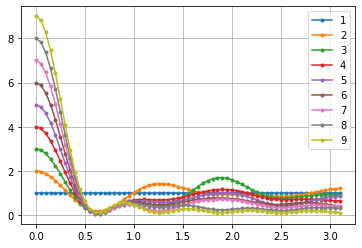

In [36]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

# plt.yscale('log')
plt.legend()
plt.grid()

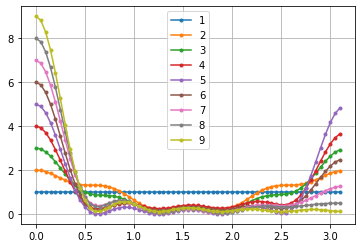

In [12]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

# plt.yscale('log')
plt.legend()
plt.grid()

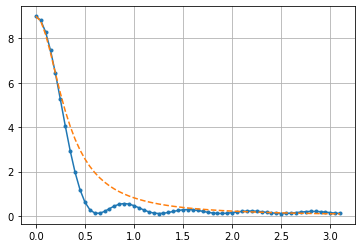

In [34]:
i = 9

plt.plot(out[0], Sk[i], '.-')

S0 = i
xi2 = 10

plt.plot(out[0], S0/(1 + xi2*out[0]**2), '--')
# plt.yscale('log')
plt.grid()

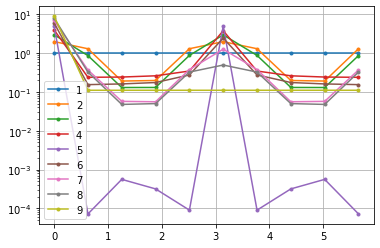

In [67]:
for i in Sk.keys():
    plt.plot(out[0], Sk[i], '.-', label=i)

plt.yscale('log')
plt.legend()
plt.grid()

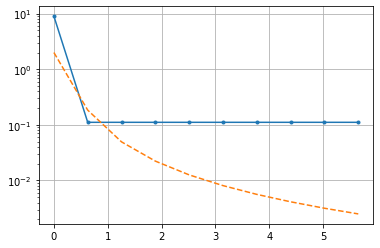

In [64]:
plt.plot(out[0], out[1], '.-')

S0 = 2
xi2 = 25
plt.plot(out[0], S0/(1 + xi2*out[0]**2), '--')

plt.yscale('log')
plt.grid()

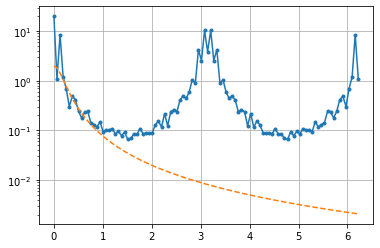

In [53]:
plt.plot(out[0], out[1], '.-')

S0 = 2
xi2 = 25
plt.plot(out[0], S0/(1 + xi2*out[0]**2), '--')

plt.yscale('log')
plt.grid()

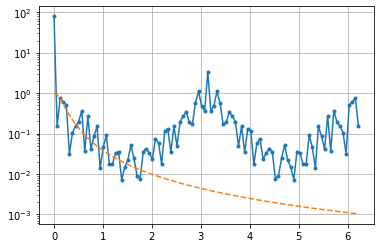

In [41]:
plt.plot(out[0], out[1], '.-')

xi2 = 25
plt.plot(out[0], 1/(1 + xi2*out[0]**2), '--')

plt.yscale('log')
plt.grid()

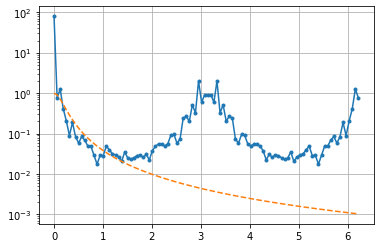

In [38]:
plt.plot(out[0], out[1], '.-')

xi2 = 25
plt.plot(out[0], 1/(1 + xi2*out[0]**2), '--')

plt.yscale('log')
plt.grid()